<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [15]:
# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
from spacy import displacy
import squarify

nlp = spacy.load("en_core_web_lg")

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

### Load Dataset

In [4]:
file = 'data/job_listings.csv'
df = pd.read_csv(file, usecols=['title', 'description'])[['title', 'description']]
df.head()

,title,description
0,Data scientist,"b""<div><div>Job Requirements:</div><ul><li><p>..."
1,Data Scientist I,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...
2,Data Scientist - Entry Level,b'<div><p>As a Data Scientist you will be work...
3,Data Scientist,"b'<div class=""jobsearch-JobMetadataHeader icl-..."
4,Data Scientist,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...


### Data Wrangling

In [5]:
# remove html code
from bs4 import BeautifulSoup

def remove_html(df):
    df = df.copy()
    df['description'] = df['description'].str.replace('b"', '')
    df['description'] = df['description'].str.replace("b'", '')
    df = df.applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())
    return df

df = remove_html(df)
df.head()

,title,description
0,Data scientist,Job Requirements:\nConceptual understanding in...
1,Data Scientist I,"Job Description\n\nAs a Data Scientist 1, you ..."
2,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,Data Scientist,Location: USA \xe2\x80\x93 multiple locations\...


In [6]:
def remove_unicode_chars(df):
    df = df.copy()
    df['description'] = df['description'].str.replace(r'(\\(x|n)[a-z0-9]{0,2})', ' ')
    return df
df = remove_unicode_chars(df)
df.head()

,title,description
0,Data scientist,Job Requirements: Conceptual understanding in ...
1,Data Scientist I,"Job Description As a Data Scientist 1, you wi..."
2,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,Data Scientist,Location: USA multiple locations + years o...


In [7]:
df.loc[4, 'description']

"Location: USA     multiple locations + years of Analytics experience Understand business requirements and technical requirements Can handle data extraction, preparation and transformation Create and implement data models'"

In [8]:
df.loc[13, 'description']

"As Spotify Premium swells to over 96M subscribers around the globe, we are looking for new ways to continue to grow our subscription business. You would be joining Spotify on the Premium Analytics team, a core business strategy and insights team, as an Associate Data Scientist. In this unique position, your work would be essential in shaping how Spotify is able to grow through data-driven recommendations, new product offerings and innovative marketing efforts. You will see first hand how your work translates into new strategies, products, and consumer experiences as we enter a new phase in Spotify Premium   s life.  You will work with a global team of world-class analysts, data scientists, business managers, marketers, and engineers. We are all passionate about what we do and move forward with high impact projects at a high pace. Learning and improving is part of our daily routine, and you will be free to develop your own skills and ways of working. At your fingertips you   ll have ac

In [9]:
df.loc[9, 'description']

"Slack is hiring experienced data scientists to join our Lifecycle team. The Lifecycle team   s mission is to build product experiences that help companies of all sizes adopt and scale Slack within their organization. These product experiences include team and user onboarding, payments and billing systems, and the marketing and packaging of paid plans.  You will use data to help the team discover opportunities and define appropriate solutions to user problems by performing research into user behavior, defining and applying experimentation standards, and understanding the drivers of business performance.  Slack has a positive, diverse, and supportive culture   we look for people who are curious, inventive, and work to be a little better every single day. In our work together we aim to be smart, humble, hardworking and, above all, collaborative. If this sounds like a good fit for you, why not say hello?  What you will be doing  Use data to influence the direction of team roadmaps and inf

In [10]:
df.loc[9, 'description']

"Slack is hiring experienced data scientists to join our Lifecycle team. The Lifecycle team   s mission is to build product experiences that help companies of all sizes adopt and scale Slack within their organization. These product experiences include team and user onboarding, payments and billing systems, and the marketing and packaging of paid plans.  You will use data to help the team discover opportunities and define appropriate solutions to user problems by performing research into user behavior, defining and applying experimentation standards, and understanding the drivers of business performance.  Slack has a positive, diverse, and supportive culture   we look for people who are curious, inventive, and work to be a little better every single day. In our work together we aim to be smart, humble, hardworking and, above all, collaborative. If this sounds like a good fit for you, why not say hello?  What you will be doing  Use data to influence the direction of team roadmaps and inf

In [11]:
df.loc[39, 'description']

"$138,579 a yearCollects and analyzes statistics and information from multiple sources to spot trends and to gain maximum insight that can give the company a competitive advantage, and communicates informed conclusions and recommendations across an organization   s leadership structure. Strategizes and identifies unique opportunities to locate and collect new data, explores and mines data from many angles, and determines what it means. Communicates data findings to both business and IT leaders to influence how an organization approaches and meets business challenges of an evolving customer base and changing marketplace, using strong business acumen. Finds and recommends new uses for existing data sources; designs, modifies, and builds new data processes; and builds large, complex data sets.  Positions that fall within this class include management personnel, scrum masters, product owners, program managers, consultants, machine learning engineers, software developers, software architect

## 2) Use Spacy to tokenize / clean the listings 

In [26]:
STOP_WORDS = nlp.Defaults.stop_words.union(['data', 'science'])
df['tokens'] = df['description'].apply(lambda x: [token.lemma_ for token in nlp(x) if (token not in STOP_WORDS) and (token.is_punct != True)])
df.sample(10)

,title,description,tokens
288,DATA SCIENTIST/ 40 HOURS/ DAYS/ BWH SLEEP MEDI...,The Data Scientist will work autonomously and ...,"[the, Data, Scientist, will, work, autonomousl..."
322,2019 PhD University Graduate - Data Scientist ...,"At Uber, we ignite opportunity by setting the ...","[at, Uber, -PRON-, ignite, opportunity, by, se..."
13,Associate Data Scientist – Premium Analytics,As Spotify Premium swells to over 96M subscrib...,"[as, Spotify, Premium, swell, to, over, 96, M,..."
158,"Data Scientist, Alexa Shopping NLU",Bachelor or Master's degree in highly quantita...,"[Bachelor, or, Master, 's, degree, in, highly,..."
47,Data Scientist,Description A rare opportunity to join the dev...,"[description, a, rare, opportunity, to, join, ..."
231,Data Scientist - Oil and Gas,Position Overview Our Oil and Gas division is ...,"[position, Overview, -PRON-, Oil, and, gas, di..."
298,Data Scientist,The Data Scientist will perform analysis and m...,"[the, Data, Scientist, will, perform, analysis..."
183,Investigative Data Scientist,Channel and Intellectual Property Protection S...,"[Channel, and, Intellectual, Property, Protect..."
36,Data Scientist,Position Summary In today s fast evolving te...,"[position, Summary, in, today, , s, fast, ev..."
321,Sr Data Scientist,"Join a team recognized for leadership, innovat...","[join, a, team, recognize, for, leadership, in..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [27]:
count_vect = CountVectorizer()

dtm = count_vect.fit_transform(df['description'])
dtm_df = pd.DataFrame(dtm.todense(),columns=count_vect.get_feature_names())
dtm_df.head()

,00,000,02115,03,0356,04,05,062,06366,08,10,100,1000,1001,1008,100k,100x,105,1079302,1082692,10b,10ms,10x,11,110k,112,114157802,12,120,125,126,130,1315,1324b,138,14,140,15,150,15000,159m,16,1605,165,169334br,17,170,17b,18,180,180008jq,18b,19,190,190007ji,19000bn4,19000c1k,19004162,1901744,1904,1904labs,1905,19050,1938,1944,1967,1971,1975,1979,1988,199,1994,1999,1b,1k,1st,1strategy,1tb,20,200,2000,200020183,200041695,2004,2008,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2050,21,210,2145,2272,...,wipro,wire,wireless,wireline,wisconsin,wisdom,wish,with,withdraw,within,without,wizard,wm,wolferman,women,won,worcester,word,word2vec,words,work,workday,worked,worker,workers,workersdevelop,workflow,workflows,workforce,working,workings,workload,workplace,works,workshops,workspace,world,worldgrid,worldline,worldwide,worth,wotif,would,wow,wowing,wrangle,wrangler,wrangles,wrangling,wrapped,write,writers,writing,written,writtenproven,wrk,wwe,www,xbox,xgboost,xp,xpo,xual,yards,year,yeara,yearas,yearcollects,yeardescription,yearjob,yearlrs,years,yearsexperience,yearsummary,yearthe,yeartitle,yearworking,yes,yet,yeti,yield,york,you,young,your,yours,yourself,youtube,yrs,zenreach,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

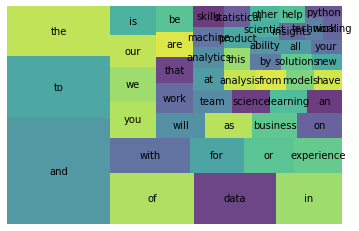

In [28]:
word_ranks = dtm_df.sum().sort_values(ascending=False)
squarify.plot(sizes=word_ranks.values[:50], label=word_ranks.index[:50], alpha=0.8)
plt.axis('off')
plt.show();

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [ ]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english')

dtm_tfidf = tfidf.fit_transform(jobs.description_clean.values)
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.todense(),columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm_tfidf_df.head()

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [ ]:
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm_tfidf_df)

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 